In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [31]:
c2w1 = np.array([0.34303784370422363,
                 -0.8594792485237122,
                 0.3789729177951813,
                 3.7897279262542725,
                 0.9393215775489807,
                 0.3138796091079712,
                 -0.13839992880821228,
                 -1.3840025663375854,
                 0.0,
                 0.40345385670661926,
                 0.9150000214576721,
                 9.149999618530273,
                 0.0,
                 0.0,
                 0.0,
                 1.0])
c2w1 = c2w1.reshape(4, 4)

In [32]:
H = 400 # Height of an image
W = 400 # Width of an image
f = 1200 # Focal distance

In [33]:
c2w = c2w1
    
rays_o = np.zeros((H*W, 3)) # Focal origin
rays_d = np.zeros((H*W, 3)) # Direction of each ray

u = np.arange(W)
v = np.arange(H)
u, v = np.meshgrid(u, v) # initialize image grid

# origin: focal of the camera
# direction: straight line between origin and pixels in the image
dirs = np.stack((u - W / 2,
                 -(v - H / 2),
                 -np.ones_like(u) * f), axis=-1) # stack the 3 vectors together

# because there is not unsqueeze in numpy, but it do have squeeze
dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)

rays_d = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True) # normalize the direction vector
rays_d = rays_d.reshape(-1, 3)


rays_o += c2w[:3, 3]

In [34]:
def plot_rays(o, d, t):
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection='3d')

    pt1 = o
    pt2 = o + t * d # where the ray is after time t

    for p1, p2 in zip(pt1[::10], pt2[::10]): # merge 2 stuff together (pytorch)
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]])

    plt.show()

In [47]:
# plot_rays(rays_o, rays_d, 1)

In [82]:
class Sphere:
    def __init__(self, position, radius, color):
        self.position = position
        self.radius = radius
        self.color = color

    def intersect(self, x):
        # To make sure point x is inside the sphere so that it contains volume
        """
        :param x: [batch_size, 3]
        """
        cond = (x[:, 0] - self.position[0])**2 + (x[:, 1] - self.position[1])**2 + (x[:, 2] - self.position[2])**2 <= self.radius**2

        num_rays = x.shape[0] # length of first dimension
        colors = torch.zeros((num_rays, 3))
        density = torch.zeros((num_rays, 1))
        colors[cond] = self.color
        density[cond] = 2

        color_condition = x[:, 0] < 0
        # 把x<0的地方的Red值存到temp里面
        temp = colors[color_condition, 0].clone()
        # 把x<0的地方的Green值存到Red里面，因为我们传进去的是全红，
        # 所以其实这步是把这些地方的Red设为0
        colors[color_condition, 0] = colors[color_condition, 1].clone()
        # 最后把x<0的地方的绿色的值设为temp，等于说把红色的值移到绿色去
        colors[color_condition, 1] = temp

        return colors, density

In [83]:
s = Sphere(np.array([0., 0., -1.]), .1, np.array([1., 0., 0.]))

In [84]:
def compute_accumulated_transmittance(betas):
    # Returns the cumulative product of elements of input in the dimension dim.
    accumulated_transmittance = torch.cumprod(betas, 1)
    # [:-1]: returns the values except the last one.
    accumulated_transmittance[:, 1:] = accumulated_transmittance[:, :-1]
    accumulated_transmittance[:, 0] = 1.
    return accumulated_transmittance


In [85]:
# tn, tf represent near and far bound
def rendering(model, rays_o, rays_d, tn, tf, num_bins=100, device='cpu'):
    t = torch.linspace(tn, tf, num_bins).to(device) # size: [num_bins]

    # 1: start from 1,
    # -1: start from 0, not include -1
    # delta_i is the distance between adjacent samples.
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10])))


    """
    shape:
    t: [num_bins]
    ray_o: [num_rays, 3]
    We want x: [num_rays, num_bins, 3]
    Because for each ray, we need num_bins points,
    the extra 3 dimensions contain position info.
    So in order to get that dimension, virtual dimensions are
    added like:
    t: [1, num_bins, 1]
    ray_o: [num_rays, 1, 3]
    !!!!x currently is many many empty rays with many bins!!!!
    we intersect the model with x, then we can get
    many rendered rays.
    """
    x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1)
    # Now x: [batch_size, 3]
 
    colors, density = model.intersect(x.reshape(-1, 3))

    colors = colors.reshape((x.shape[0], num_bins, 3)) # [num_rays, num_bins, 3]
    density = density.reshape((x.shape[0], num_bins)) # [num_rays, num_bins]

    alpha = 1 - torch.exp(-density * delta.unsqueeze(0)) # [num_rays, num_bins]
    T = compute_accumulated_transmittance(1 - alpha)
    c = (T.unsqueeze(-1) * alpha.unsqueeze(-1) * colors).sum(1) # [num_rays, 3] because sum(1)
    
    return c

In [86]:
target_model = Sphere(torch.tensor([-0.5, 0, 0]), 1, torch.tensor([1., 0., 0.]))
px_colors = rendering(target_model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 8, 12)

In [87]:
img = px_colors.reshape(H, W, 3).cpu().numpy()

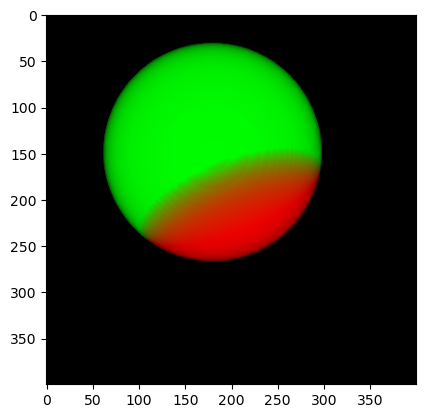

In [88]:
plt.imshow(img)
plt.show()

In [10]:
# This is my target model
target_model = Sphere(torch.tensor([0, 0, 0]), 1, torch.tensor([1., 0., 0.]))

# This is the target color
target_color = rendering(target_model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 8, 12)
color_to_optimize = torch.tensor([0., 1., 0.], requires_grad=True)
optimizer = torch.optim.SGD({color_to_optimize}, lr=1)

In [11]:
for epoch in range(100):
    # I want to optimize the color to retrieve an image similar to target
    model_to_optimize = Sphere(torch.tensor([0., 0., -1]), 0.1, color_to_optimize)

    Ax = rendering(model_to_optimize, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 0.8, 1.2)

    loss = ((Ax - target_color) ** 2).mean()
    optimizer.zero_grad()
    # call backward() to let grad of color_to_optimize be calculated.
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        temporal_image = Ax.reshape(H, W, 3).cpu().data.numpy()
        # plt.imshow(temporal_image)
        # plt.show()

KeyboardInterrupt: 